In [ ]:
import io
import requests

In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np

In [485]:
from google.colab import auth
from google.colab import files
from googleapiclient.discovery import build
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Data Work

In [ ]:
file_id = "12l2p5Hgbrn4qViwkY6SHm-4WDhPqQdoD"
url = f"https://drive.google.com/uc?id={file_id}"
df_tmc = pd.read_csv(url)

In [ ]:
file_id = "1CLZFscFiMc2hFclbLIgQEACqSkAIpWYp"
url = f"https://drive.google.com/uc?id={file_id}"
df_ghg = pd.read_csv(url, index_col=0)

In [ ]:
df_tmc.head()

,_id,count_id,count_date,location_name,longitude,latitude,centreline_type,centreline_id,px,start_time,...,w_appr_bus_t,w_appr_bus_l,n_appr_peds,s_appr_peds,e_appr_peds,w_appr_peds,n_appr_bike,s_appr_bike,e_appr_bike,w_appr_bike
0,1,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T07:30:00,...,0,0,3,0,60,0,4,0,0,0
1,2,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T07:45:00,...,0,0,0,0,54,0,3,0,0,0
2,3,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T08:00:00,...,0,0,2,1,86,0,2,0,0,0
3,4,39339,2020-01-22,Islington Ave / Market Garden Mews,-79.514446,43.622903,2,20141933,NaN,2020-01-22T13:45:00,...,0,0,0,0,1,0,0,0,0,0
4,5,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T08:15:00,...,0,0,3,0,105,0,2,1,0,0


In [ ]:
df_ghg = df_ghg.transpose()
df_ghg.dropna(axis=1, how='all', inplace=True)
df_ghg = df_ghg.iloc[:-1 , :]
df_ghg.index.name = 'year'
df_ghg.index = (df_ghg.index.astype(int) + 2).astype(str)

In [ ]:
df_ghg.columns

Index(['Total GHG Emissions Including Electricity (Mt of CO2e)a,b,d,e,f',
       'Residential (Mt of CO2e)a,b,e', 'Space Heating', 'Water Heating',
       'Appliances', 'Major Appliances', 'Other Appliances1', 'Lighting',
       'Space Cooling', 'Commercial/Institutional (Mt of CO2e)a,c,e',
       'Space Heating', 'Water Heating', 'Auxiliary Equipment',
       'Auxiliary Motors', 'Lighting', 'Space Cooling', 'Street Lightingg',
       'Industrial (Mt of CO2e)a,e,f',
       'Mining , Quarrying, and Oil and Gas Extraction', 'Pulp and Paper',
       'Iron and Steel', 'Smelting and Refining', 'Cement', 'Chemicals',
       'Petroleum Refining', 'Other Manufacturing', 'Forestry ',
       'Construction', 'Total Transportation (Mt of CO2e)a,d,e',
       'Passenger Transportation (Mt of CO2e)a,d,e', 'Cars', 'Light Trucks',
       'Motorcycles', 'Buses', 'Air', 'Rail',
       'Freight Transportation (Mt of CO2e)a,d,e', ' Light Trucks',
       ' Medium Trucks', ' Heavy Trucks', ' Air', ' Rail', '

In [ ]:
df_ghg['Buses/Heavy'] = df_ghg['Buses'] + df_ghg[' Light Trucks'] + df_ghg[' Medium Trucks'] + df_ghg[' Heavy Trucks']
df_ghg = df_ghg[['Total GHG Emissions Including Electricity (Mt of CO2e)a,b,d,e,f', 'Cars', 'Buses/Heavy']]
df_ghg.rename(columns={'Total GHG Emissions Including Electricity (Mt of CO2e)a,b,d,e,f': 'Emissions (Mt of CO2e)'}, inplace=True)
df_ghg.columns = [x.lower() for x in df_ghg.columns]

In [ ]:
df_ghg.head()

,emissions (mt of co2e),cars,buses/heavy
year,,,
2002,466.4,43.9,53.5
2003,464.6,43.5,53.3
2004,470.6,44.6,53.4
2005,488.4,44.1,57.9
2006,491.8,43.6,60.5


In [ ]:
df_tmc

,_id,count_id,count_date,location_name,longitude,latitude,centreline_type,centreline_id,px,start_time,...,w_appr_bus_t,w_appr_bus_l,n_appr_peds,s_appr_peds,e_appr_peds,w_appr_peds,n_appr_bike,s_appr_bike,e_appr_bike,w_appr_bike
0,1,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T07:30:00,...,0,0,3,0,60,0,4,0,0,0
1,2,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T07:45:00,...,0,0,0,0,54,0,3,0,0,0
2,3,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T08:00:00,...,0,0,2,1,86,0,2,0,0,0
3,4,39339,2020-01-22,Islington Ave / Market Garden Mews,-79.514446,43.622903,2,20141933,NaN,2020-01-22T13:45:00,...,0,0,0,0,1,0,0,0,0,0
4,5,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08T08:15:00,...,0,0,3,0,105,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254557,254558,107837,2023-11-30,William R Allen Rd / De Boers Dr,-79.463730,43.751758,2,20230204,2127.0,2023-11-30T17:00:00,...,0,0,0,0,0,9,0,0,0,0
254558,254559,107836,2023-11-30,William R Allen Rd / Rimrock Rd,-79.465018,43.757757,2,13449330,1997.0,2023-11-30T10:30:00,...,0,0,6,0,4,1,0,0,0,0
254559,254560,107836,2023-11-30,William R Allen Rd / Rimrock Rd,-79.465018,43.757757,2,13449330,1997.0,2023-11-30T11:00:00,...,0,0,4,0,0,3,0,0,0,0
254560,254561,107836,2023-11-30,William R Allen Rd / Rimrock Rd,-79.465018,43.757757,2,13449330,1997.0,2023-11-30T11:15:00,...,0,0,2,0,1,2,0,0,0,0


In [ ]:
#Start and end to date time objects
df_tmc['start_time'] = pd.to_datetime(df_tmc['start_time'])
df_tmc['end_time'] = pd.to_datetime(df_tmc['end_time'])

#Getting hour and date from start time
df_tmc['hour'] = df_tmc['start_time'].dt.hour
df_tmc['date'] = df_tmc['start_time'].dt.date

#Filtering for certain columns and summing each row
df_tmc['total_cars'] = df_tmc.filter(like='_appr_cars_').sum(axis=1)
df_tmc['total_trucks'] = df_tmc.filter(like='_appr_truck_').sum(axis=1)
df_tmc['total_buses'] = df_tmc.filter(like='_appr_bus_').sum(axis=1)
df_tmc['total_peds'] = df_tmc.filter(like='_appr_peds').sum(axis=1)
df_tmc['total_bikes'] = df_tmc.filter(like='_appr_bike').sum(axis=1)

#Summing based on groups at higher granularity
traffic_overview = df_tmc.groupby(['location_name', 'date', 'hour'])[
    ['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes']].sum().reset_index()

#Dropping all vehicle total columns
df_tmc_cleaned = df_tmc.drop(columns=['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes'])

#Left merging cleaned and traffic overview dfs based on certain columns (keeping all cleaned)
df_tmc_merged = df_tmc_cleaned.merge(traffic_overview,
                                     on=['location_name', 'date', 'hour'],
                                     how='left')
df_tmc = df_tmc_merged

#Sorting based on vehicle totals (descending)
top_cars = df_tmc_merged.sort_values(by="total_cars", ascending=False)
top_trucks = df_tmc_merged.sort_values(by="total_trucks", ascending=False)
top_buses = df_tmc_merged.sort_values(by="total_buses", ascending=False)
top_bikes = df_tmc_merged.sort_values(by="total_bikes", ascending=False)
top_peds = df_tmc_merged.sort_values(by="total_peds", ascending=False)

In [ ]:
df_tmc['total_traffic'] = df_tmc[['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes']].sum(axis=1)

In [ ]:
top_cars.head(10)
top_trucks.head(10)
top_buses.head(10)

,_id,count_id,count_date,location_name,longitude,latitude,centreline_type,centreline_id,px,start_time,...,s_appr_bike,e_appr_bike,w_appr_bike,hour,date,total_cars,total_trucks,total_buses,total_peds,total_bikes
135960,135961,48251,2023-01-31,Steeles Ave E,-79.355119,43.812484,2,14228218,1261.0,2023-01-31 08:15:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
136406,136407,48279,2023-01-31,Steeles Ave E,-79.305496,43.824067,2,13441803,NaN,2023-01-31 08:00:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
135832,135833,48243,2023-01-31,Steeles Ave E,-79.392740,43.804041,2,14228180,1859.0,2023-01-31 08:15:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
135833,135834,48243,2023-01-31,Steeles Ave E,-79.392740,43.804041,2,14228180,1859.0,2023-01-31 08:30:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
135834,135835,48243,2023-01-31,Steeles Ave E,-79.392740,43.804041,2,14228180,1859.0,2023-01-31 08:45:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
135959,135960,48251,2023-01-31,Steeles Ave E,-79.355119,43.812484,2,14228218,1261.0,2023-01-31 08:00:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
136409,136410,48279,2023-01-31,Steeles Ave E,-79.305496,43.824067,2,13441803,NaN,2023-01-31 08:45:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
136408,136409,48279,2023-01-31,Steeles Ave E,-79.305496,43.824067,2,13441803,NaN,2023-01-31 08:30:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
136407,136408,48279,2023-01-31,Steeles Ave E,-79.305496,43.824067,2,13441803,NaN,2023-01-31 08:15:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0
135961,135962,48251,2023-01-31,Steeles Ave E,-79.355119,43.812484,2,14228218,1261.0,2023-01-31 08:30:00,...,0,0,0,8,2023-01-31,12435,260,277,75,0


In [ ]:
df_tmc.head()

,_id,count_id,count_date,location_name,longitude,latitude,centreline_type,centreline_id,px,start_time,...,e_appr_bike,w_appr_bike,hour,date,total_cars,total_trucks,total_buses,total_peds,total_bikes,total_traffic
0,1,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08 07:30:00,...,0,0,7,2020-01-08,344,1,49,117,7,518
1,2,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08 07:45:00,...,0,0,7,2020-01-08,344,1,49,117,7,518
2,3,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08 08:00:00,...,0,0,8,2020-01-08,827,7,105,408,8,1355
3,4,39339,2020-01-22,Islington Ave / Market Garden Mews,-79.514446,43.622903,2,20141933,NaN,2020-01-22 13:45:00,...,0,0,13,2020-01-22,2383,37,22,8,0,2450
4,5,39337,2020-01-08,Erindale Ave / Broadview Ave / Broadview Subwa...,-79.358652,43.677521,2,13462138,NaN,2020-01-08 08:15:00,...,0,0,8,2020-01-08,827,7,105,408,8,1355


In [ ]:
df_tmc['year'] = pd.to_datetime(df_tmc['start_time']).dt.year

yearly_totals = df_tmc.groupby('year').agg({
    'total_cars': 'sum',
    'total_trucks': 'sum',
    'total_buses': 'sum',
    'total_peds': 'sum',
    'total_bikes': 'sum'
}).reset_index()

df_ghg = df_ghg.reset_index()
df_ghg['year'] = df_ghg['year'].astype(int)
df_ghg = pd.merge(
    df_ghg,
    yearly_totals,
    on='year',
    how='left'
)

df_ghg['total_car_emissions'] = df_tmc['total_cars'] * df_ghg['cars']
df_ghg['total_bus_emissions'] = df_tmc['total_buses'] * df_ghg['buses/heavy']
df_ghg['total_truck_emissions'] = df_tmc['total_trucks'] * df_ghg['buses/heavy']
df_ghg['total_ped_emissions'] = df_tmc['total_peds'] * 0
df_ghg['total_bike_emissions'] = df_tmc['total_bikes'] * 0

df_ghg['total_emissions'] = (
    df_ghg['total_car_emissions'] + df_ghg['total_bus_emissions'] +
    df_ghg['total_truck_emissions'] + df_ghg['total_ped_emissions'] +
    df_ghg['total_bike_emissions']
)

df_ghg.set_index('year', inplace=True)
df_ghg = df_ghg[df_ghg.index >= 2020]
df_ghg.head()

,emissions (mt of co2e),cars,buses/heavy,total_cars,total_trucks,total_buses,total_peds,total_bikes,total_car_emissions,total_bus_emissions,total_truck_emissions,total_ped_emissions,total_bike_emissions,total_emissions
year,,,,,,,,,,,,,,
2020,506.9,33.8,72.8,33443601.0,3140576.0,619578.0,6167515.0,1244470.0,29270.8,5096.0,291.2,0,0,34658.0
2021,510.6,33.2,73.0,41936485.0,1248595.0,685881.0,7859461.0,1716190.0,28751.2,5110.0,292.0,0,0,34153.2
2022,446.4,26.2,61.8,89061832.0,2661069.0,1468510.0,18517784.0,2022476.0,22689.2,4326.0,247.2,0,0,27262.4
2023,458.6,26.0,66.4,52986296.0,1154615.0,879655.0,7688981.0,884264.0,24024.0,4913.6,464.8,0,0,29402.4


In [ ]:
df_unique = df_tmc.drop_duplicates(subset=["centreline_id"], keep='first').reset_index(drop=True)

coordinates = np.radians(df_unique[['latitude', 'longitude']].values)

tree = BallTree(coordinates, metric='haversine')

distances, indices = tree.query(coordinates, k=2)

earth_radius = 6371000
df_unique['distance_to_closest'] = distances[:, 1] * earth_radius

df_unique['closest_intersection'] = [df_unique.loc[idx[1], 'location_name'] for idx in indices]

df_unique = df_unique[['centreline_id', 'location_name', 'closest_intersection', 'distance_to_closest']]
df_intersections = df_unique.sort_values(by='distance_to_closest')

In [ ]:
location_traffic = df_tmc.groupby(['location_name']).agg({
    'total_traffic': 'sum',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

location_traffic.rename(columns={
    'location_name': 'closest_intersection',
    'total_traffic': 'total_traffic_intersection',
    'latitude': 'latitude_intersection',
    'longitude': 'longitude_intersection'
}, inplace=True)

df_intersections = pd.merge(df_intersections, location_traffic, on='closest_intersection', how='left')
location_traffic.rename(columns={
    'closest_intersection': 'location_name',
    'total_traffic_intersection': 'total_traffic_location',
    'latitude_intersection': 'latitude_location',
    'longitude_intersection': 'longitude_location'
}, inplace=True)

df_intersections = pd.merge(df_intersections, location_traffic, on='location_name', how='left')

## Training Models

In [ ]:
traffic_features = ['total_cars', 'total_trucks', 'total_buses', 'total_bikes', 'total_peds']
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_tmc[traffic_features])
df_tmc['congestion_cluster'] = clusters

In [ ]:
categorical_features = ['location_name']
numerical_features = ['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes', 'hour']
target = 'bus_delay'

#Estimate Bus Delay
df_tmc['bus_density'] = df_tmc['total_buses'] / (df_tmc['total_traffic'] + 1)
df_tmc['bus_delay'] = df_tmc['bus_density'] * df_tmc['total_cars']

df_tmc = df_tmc.dropna(subset=numerical_features + [target])

df_tmc[categorical_features] = df_tmc[categorical_features].fillna('Unknown')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X = df_tmc[numerical_features + categorical_features]
y = df_tmc[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('xgb', xgb_model)])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost Bus Delay Prediction MSE: {mse:.2f}")
print(f"XGBoost Bus Delay Prediction MAE: {mae:.2f}")

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [4, 6, 8]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

y_pred_best = grid_search.best_estimator_.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred_best)
best_mae = mean_absolute_error(y_test, y_pred_best)
print(f"Optimized XGBoost Bus Delay Prediction MSE: {best_mse:.2f}")
print(f"Optimized XGBoost Bus Delay Prediction MAE: {best_mae:.2f}")

# Visualizations

### Emissions

In [ ]:
df_intersections.head()

,centreline_id,location_name,closest_intersection,distance_to_closest,total_traffic_intersection,latitude_intersection,longitude_intersection,total_traffic_location,latitude_location,longitude_location
0,13458311,Eglinton Ave W / Westover Hill Rd,Eglinton Ave W / Glenarden Rd,6.409644,457368,43.699457,-79.432770,121876,43.699441,-79.432847
1,13458307,Eglinton Ave W / Glenarden Rd,Eglinton Ave W / Westover Hill Rd,6.409644,121876,43.699441,-79.432847,457368,43.699457,-79.432770
2,13470726,Lake Shore Blvd W / Forty First St,Lake Shore Blvd W / Brow Dr,8.647674,73996,43.590516,-79.544952,75868,43.590449,-79.545007
3,13470724,Lake Shore Blvd W / Brow Dr,Lake Shore Blvd W / Forty First St,8.647674,75868,43.590449,-79.545007,73996,43.590516,-79.544952
4,13458248,Eglinton Ave W / Old Park Rd,Eglinton Ave W / Glen Cedar Rd,11.209647,500799,43.699858,-79.430884,230488,43.699830,-79.431018


In [ ]:
traffic_hourly = df_tmc.groupby('hour')[['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes']].sum().reset_index()

fig = px.line(traffic_hourly, x='hour', y=['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes'],
              markers=True, title='Traffic Volume Trends by Hour',
              labels={'value': 'Total Count', 'hour': 'Hour of Day'},
              template='plotly_dark')

fig.update_layout(hovermode='x')
fig.show()

In [ ]:
location_traffic = df_tmc.groupby('location_name')[['total_cars', 'total_trucks', 'total_buses']].sum().reset_index()
top_locations = location_traffic.sort_values(by='total_cars', ascending=False).head(10)

fig = px.bar(top_locations, x='location_name', y=['total_cars', 'total_trucks', 'total_buses'],
             title='Top 10 Most Congested Locations',
             labels={'value': 'Total Vehicles', 'location_name': 'Intersection'},
             barmode='stack', template='plotly_dark')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
fig = px.scatter(df_tmc, x='total_cars', y='total_trucks', size='total_buses',
                 color='location_name', hover_name='location_name',
                 title='Traffic Composition: Cars vs. Trucks vs. Buses',
                 labels={'total_cars': 'Total Cars', 'total_trucks': 'Total Trucks'},
                 template='plotly_dark')

fig.update_layout(legend_title_text='Location')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
bottom_cars = location_traffic.sort_values(by='total_cars', ascending=True).head(10)

fig = px.bar(bottom_cars, x='location_name', y=['total_cars', 'total_trucks', 'total_buses'],
             title='Bottom 10 Least Congested Locations',
             labels={'value': 'Total Vehicles', 'location_name': 'Intersection'},
             barmode='stack', template='plotly_dark')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

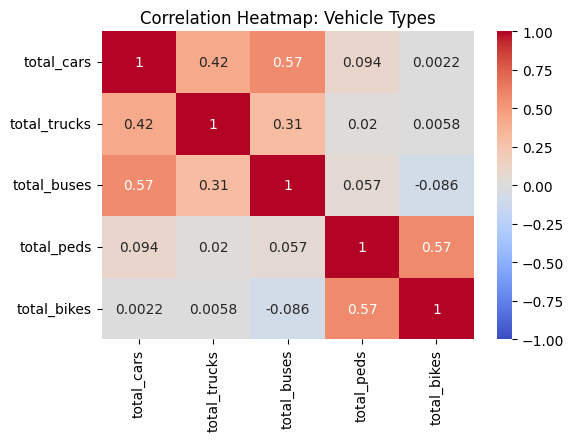

In [492]:
correlation = df_tmc[['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Heatmap: Vehicle Types')
plt.show()

In [ ]:
daily_traffic = df_tmc.groupby('date')[
    ['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes']
].sum().reset_index()

fig = px.line(daily_traffic, x='date', y=['total_cars', 'total_trucks', 'total_buses', 'total_peds', 'total_bikes'],
              title='Daily Traffic Trends by Vehicle Type',
              labels={'value': 'Total Count', 'date': 'Date'},
              template='plotly_dark')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
fig = px.scatter(df_tmc, x='total_cars', y='total_bikes',
                 title='Relationship Between Cars and Bikes',
                 labels={'total_cars': 'Total Cars', 'total_bikes': 'Total Bikes'},
                 template='plotly_dark')
fig.show()

fig = px.scatter(df_tmc, x='total_cars', y='total_peds',
                 title='Relationship Between Cars and Pedestrians',
                 labels={'total_cars': 'Total Cars', 'total_peds': 'Total Pedestrians'},
                 template='plotly_dark')
fig.show()

fig = px.scatter(df_tmc, x='total_cars', y='total_trucks',
                 title='Relationship Between Cars and Trucks',
                 labels={'total_cars': 'Total Cars', 'total_trucks': 'Total Trucks'},
                 template='plotly_dark')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df_ghg.index, y=df_ghg['total_emissions'], mode='lines+markers', name='Total Emissions', line=dict(color='crimson')))
fig1.update_layout(title='Total Emissions Over Time (All Vehicles)', xaxis_title='Year', yaxis_title='Total Emissions (kg CO2)', template='plotly_dark')
fig1.show()

In [ ]:
ccorrelation = df_ghg[['total_car_emissions', 'total_bus_emissions', 'total_truck_emissions']].corr()
fig3 = px.imshow(correlation, text_auto=True, color_continuous_scale='RdBu', title='Correlation Heatmap: Vehicle Emissions')
fig3.update_layout(width=600, height=400, template='plotly_dark')
fig3.show()

In [ ]:
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=df_ghg.index, y=df_ghg['total_car_emissions'], mode='lines', name='Car Emissions', line=dict(color='steelblue')))
fig4.add_trace(go.Scatter(x=df_ghg.index, y=df_ghg['total_bus_emissions'], mode='lines', name='Bus Emissions', line=dict(color='darkorange')))
fig4.add_trace(go.Scatter(x=df_ghg.index, y=df_ghg['total_truck_emissions'], mode='lines', name='Truck Emissions', line=dict(color='firebrick')))
fig4.update_layout(title='Emissions Over Time by Vehicle Type', xaxis_title='Year', yaxis_title='Emissions (kg CO2)', template='plotly_dark')
fig4.show()

In [489]:
latest_year = df_ghg.index.max()
latest_data = df_ghg.loc[latest_year]
emissions_data = [latest_data['total_car_emissions'], latest_data['total_bus_emissions'], latest_data['total_truck_emissions']]
labels = ['Car Emissions', 'Bus Emissions', 'Truck Emissions']

fig5 = go.Figure(data=[go.Pie(labels=labels, values=emissions_data, hole=0.3, textinfo='percent+label',
                              marker=dict(colors=['#4C72B0', '#DD8452', '#C44E52']))])
fig5.update_layout(title=f'Emissions Breakdown by Vehicle Type ({latest_year})', template='plotly_dark')
fig5.show()

In [ ]:
fig = px.scatter_mapbox(
    df_intersections,
    lat='latitude_location',
    lon='longitude_location',
    hover_name='location_name',
    hover_data={
        'closest_intersection': True,
        'distance_to_closest': True,
        'total_traffic_location': True,
        'total_traffic_intersection': True
    },
    size='total_traffic_location',
    color='total_traffic_intersection',
    title='Traffic Visualization by Location and Closest Intersection',
    template='plotly_dark',
    size_max=15,
    zoom=10
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [493]:
fig = px.scatter(
    df_tmc,
    x='longitude',
    y='latitude',
    color='congestion_cluster',
    color_continuous_scale='viridis',
    title='Traffic Congestion Clusters',
    labels={'color': 'Cluster'},
    template='plotly_dark',
    opacity=0.6
)

fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    coloraxis_colorbar=dict(title='Cluster')
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.